In [4]:
import wandb
from condgen.models.score_matching import ConditionalScoreMatcher
from condgen.data_utils.data_utils_MNIST import MNISTDataModule
from condgen.data_utils.data_utils_cf_traj import SimpleTrajDataModule
from condgen.models import samplers
import pytorch_lightning as pl
import torch
import numpy as np
import os

from torchvision.utils import make_grid
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tqdm 
import pandas as pd

/home/edward/.cache/pypoetry/virtualenvs/condgen-8jXrSjT1-py3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
gpu = 0
api = wandb.Api()

run = api.run(f"edebrouwer/dmm/3t5r2hao")

In [18]:
model_cls = ConditionalScoreMatcher
dataset_cls = MNISTDataModule


fname = [f.name for f in run.files() if "ckpt" in f.name][0]
run.file(fname).download(replace = True, root = ".")
model = model_cls.load_from_checkpoint(fname)
os.remove(fname)
    
hparams = dict(model.hparams)
dataset = dataset_cls(**hparams)
dataset.prepare_data()

In [19]:
device = torch.device("cuda:0")
model = model.to(device)

In [11]:
for i,b in enumerate(dataset.test_cf_dataloader()):
    X_cond, X_true, _, T_cond, T_new, X_new = b
    break

In [6]:
sample_batch_size = 4
#cond_labels = np.random.randint(9,size=sample_batch_size)
#cond = torch.nn.functional.one_hot(torch.LongTensor(cond_labels),10).float().to(device)
#sampler = samplers.ode_sampler
#sampler = samplers.pc_sampler
sampler = samplers.ode_sampler
samples = model.sample(sampler, sample_batch_size, X_cond = X_cond[:sample_batch_size].to(device), T_cond = T_cond[:sample_batch_size].to(device))

Number of function evaluations: 290


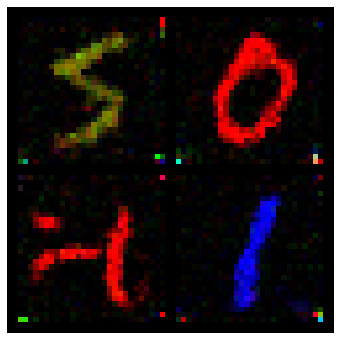

In [7]:
samples = samples.clamp(0.0, 1.0)

sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

## Abduction step

In [23]:
sample_batch_size = 8
#cond_labels = np.random.randint(9,size=sample_batch_size)
#cond = torch.nn.functional.one_hot(torch.LongTensor(cond_labels),10).float().to(device)
#sampler = samplers.ode_sampler
#sampler = samplers.pc_sampler
sampler = samplers.ode_sampler
z_samples = model.abduct(sampler, sample_batch_size, X_cond = X_cond[:sample_batch_size].to(device), T_cond = T_cond[:sample_batch_size].to(device), X_obs = X_true[:sample_batch_size].to(device))

Number of function evaluations: 338


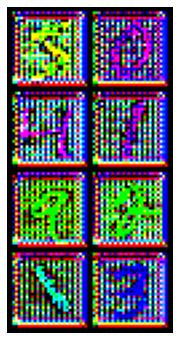

In [24]:
z_samples = z_samples.clamp(0.0, 1.0)

sample_grid = make_grid(z_samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [28]:
cf_samples = model.sample(sampler, sample_batch_size, X_cond = X_cond[:sample_batch_size].to(device), T_cond = T_new[:sample_batch_size].to(device),z = z_samples)

Number of function evaluations: 356


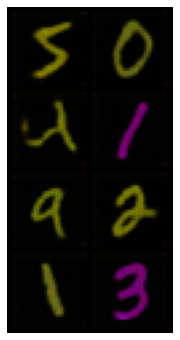

In [29]:
cf_samples = cf_samples.clamp(0.0, 1.0)

sample_grid = make_grid(cf_samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

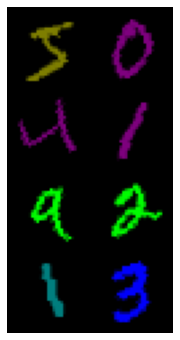

In [30]:
true_cf = X_new.clamp(0.0, 1.0)[:sample_batch_size]

sample_grid = make_grid(true_cf, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

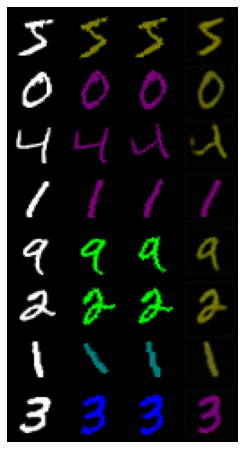

In [39]:
x_og = X_cond[:sample_batch_size].clamp(0.0,1.0).to(device)
og_grid = make_grid(x_og, nrow=1)

x_obs = X_true[:sample_batch_size].clamp(0.0,1.0).to(device)
obs_grid = make_grid(x_obs, nrow=1)

x_cf = X_new[:sample_batch_size].clamp(0.0,1.0).to(device)
cf_grid = make_grid(x_cf, nrow=1)

x_pred = cf_samples.clamp(0.0,1.0).to(device)
pred_grid = make_grid(x_pred, nrow=1)

all_grid = torch.cat((og_grid,obs_grid,cf_grid,pred_grid),2)

plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(all_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [14]:
def evaluate_run(run,dataset_cls, config):
    model_cls = ConditionalScoreMatcher
    
    ite_mode = config.get("ite_mode",False)
    treatment2 = config.get("treatment2",None)
    treatment3 = config.get("treatment3",None)

    fname = [f.name for f in run.files() if "ckpt" in f.name][0]
    run.file(fname).download(replace = True, root = ".")
    model = model_cls.load_from_checkpoint(fname)
    os.remove(fname)

    hparams = dict(model.hparams)
    dataset = dataset_cls(**hparams)
    dataset.prepare_data(ite_mode = ite_mode, treatment2 = treatment2, treatment3 = treatment3)

    device = torch.device("cuda:0")
    model = model.to(device)

    X_pred_cf = []
    X_pred_cf2 = []
    X_target_cf = []
    X_target_cf2 = []
    X_cond_list = []
    Y_fact_list = []
    
    for i,b in tqdm.tqdm(enumerate(dataset.test_cf_dataloader())):
        if len(b)==6:
            X_cond, X_true, _, T_cond, T_new, X_new = b
        if len(b)==8:
            X_cond, X_true, _, T_cond, T_new, X_new, T_new2, X_new2 = b

        sampler = samplers.ode_sampler
        #abduction
        z_samples = model.abduct(sampler,sample_batch_size = X_cond.shape[0], X_cond = X_cond.to(device), T_cond = T_cond.to(device), X_obs = X_true.to(device))
        cf_samples = model.sample(sampler, sample_batch_size = X_cond.shape[0], X_cond = X_cond.to(device), T_cond = T_new.to(device),z = z_samples)
        
        if ite_mode:
            cf_samples2 = model.sample(sampler, sample_batch_size = X_cond.shape[0], X_cond = X_cond.to(device), T_cond = T_new2.to(device),z = z_samples)
            X_target_cf2.append(X_new2)
            X_pred_cf2.append(cf_samples2)

        
        X_pred_cf.append(cf_samples)
        X_target_cf.append(X_new)
        X_cond_list.append(X_cond)
        Y_fact_list.append(X_true)

    X_pred_cf = torch.cat(X_pred_cf)
    X_target_cf = torch.cat(X_target_cf)
    X_cond = torch.cat(X_cond_list)
    Y_factual = torch.cat(Y_fact_list)
    mse = (X_pred_cf.cpu()-X_target_cf.cpu()).pow(2).mean()

    if ite_mode:
        X_target_cf2 = torch.cat(X_target_cf2)
        X_pred_cf2 = torch.cat(X_pred_cf2)
        mse_ite = ((X_target_cf2.cpu()-X_target_cf.cpu())-(X_pred_cf2.cpu()-X_pred_cf.cpu())).pow(2).mean()
        return mse_ite, X_pred_cf, X_target_cf, X_cond, Y_factual

    return mse, X_pred_cf, X_target_cf, X_cond, Y_factual

#mse = evaluate_run(run,dataset_cls = SimpleTrajDataModule)

In [15]:
"""
configs = [{"sweep_id":["rp1tjzby"],
  "model_cls":ConditionalScoreMatcher,
  "data_cls":MNISTDataModule,
  "model_name":"Diffusion",
  "data_name":"MNIST",
  "config_name":f"Diffusion abduction"}]


configs = [{"sweep_id":["1nbculs1"],
  "model_cls":ConditionalScoreMatcher,
  "data_cls":SimpleTrajDataModule,
  "model_name":"Diffusion",
  "data_name":"SimpleTraj",
  "config_name":f"Diffusion abduction"}]

"""

configs = [{"sweep_id":["3bhk49ny"],
  "model_cls":ConditionalScoreMatcher,
  "data_cls":SimpleTrajDataModule,
  "model_name":"Diffusion",
  "data_name":"CV",
  "ite_mode": True,
    "treatment2": 0.5,
"treatment3":0.8,
  "config_name":f"Diffusion abduction ITE"}]



In [16]:
fold_name = "random_seed"
df = pd.DataFrame()
api = wandb.Api()

for config in configs:

    pd_dict = {"Model":config["model_name"],"Data":config["data_name"], "Name":config["config_name"]}
    sweep_names = [sweep_id for sweep_id in config["sweep_id"]]
    
    model_cls = config["model_cls"]
    # Gathering runs from sweeps -----
    sweeps = [api.sweep(f"edebrouwer/counterfactuals/{sweep_name}") for sweep_name in sweep_names]
    sweep_runs = []
    for sweep in sweeps:
        sweep_runs += [r for r in sweep.runs]
        
    best_runs = []
    for fold in [421,422,423,424,425]:

        runs_fold = [r for r in sweep_runs if (r.config.get(fold_name)==fold) and (r.config.get("data_type")==config["data_name"])]
        if "groups" in config:
            for group_key in config["groups"].keys():
                runs_fold = [r for r in runs_fold if (r.config.get(group_key)==config["groups"][group_key])]
        
        runs_fold_sorted = sorted(runs_fold,key = lambda run: run.summary.get("restored_val_loss"), reverse = False)
        best_runs.append(runs_fold_sorted[0])
        
    mses = []
    for run in best_runs:
        mse = evaluate_run(run,dataset_cls = config["data_cls"], config = config)[0]
        mses.append(mse)
    mses = np.array(mses)
    mse_mu = mses.mean()
    mse_std = mses.std()

    mse_str = "$ " + str(mse_mu.round(3))+ "\pm" +str(mse_std.round(3)) +" $"
    pd_dict["MSE"] = mse_str
    
    df = df.append(pd_dict,ignore_index =True)
print(df.to_latex(escape = False,index= False))

0it [00:00, ?it/s]

Number of function evaluations: 788
Number of function evaluations: 518


1it [00:17, 17.70s/it]

Number of function evaluations: 518
Number of function evaluations: 782
Number of function evaluations: 530


2it [00:35, 17.84s/it]

Number of function evaluations: 548
Number of function evaluations: 770
Number of function evaluations: 512


3it [00:52, 17.60s/it]

Number of function evaluations: 512
Number of function evaluations: 752
Number of function evaluations: 500


4it [01:10, 17.42s/it]

Number of function evaluations: 518
Number of function evaluations: 770
Number of function evaluations: 506


5it [01:27, 17.52s/it]

Number of function evaluations: 524
Number of function evaluations: 764
Number of function evaluations: 506


6it [01:48, 18.51s/it]

Number of function evaluations: 506
Number of function evaluations: 770
Number of function evaluations: 506


7it [02:09, 19.41s/it]

Number of function evaluations: 512
Number of function evaluations: 818
Number of function evaluations: 506


8it [02:30, 18.84s/it]

Number of function evaluations: 524



0it [00:00, ?it/s]

Number of function evaluations: 428
Number of function evaluations: 434


1it [00:12, 12.71s/it]

Number of function evaluations: 428
Number of function evaluations: 416
Number of function evaluations: 428


2it [00:25, 12.63s/it]

Number of function evaluations: 422
Number of function evaluations: 428
Number of function evaluations: 434


3it [00:40, 14.04s/it]

Number of function evaluations: 428
Number of function evaluations: 416
Number of function evaluations: 434


4it [00:54, 13.87s/it]

Number of function evaluations: 428
Number of function evaluations: 428
Number of function evaluations: 434


5it [01:07, 13.66s/it]

Number of function evaluations: 440
Number of function evaluations: 428
Number of function evaluations: 434


6it [01:20, 13.44s/it]

Number of function evaluations: 422
Number of function evaluations: 416
Number of function evaluations: 434


7it [01:34, 13.64s/it]

Number of function evaluations: 422
Number of function evaluations: 410
Number of function evaluations: 434


8it [01:47, 13.48s/it]

Number of function evaluations: 428



0it [00:00, ?it/s]

Number of function evaluations: 488
Number of function evaluations: 476


1it [00:16, 16.95s/it]

Number of function evaluations: 464
Number of function evaluations: 500
Number of function evaluations: 464


2it [00:33, 16.79s/it]

Number of function evaluations: 452
Number of function evaluations: 500
Number of function evaluations: 464


3it [00:47, 15.62s/it]

Number of function evaluations: 458
Number of function evaluations: 506
Number of function evaluations: 464


4it [01:04, 16.05s/it]

Number of function evaluations: 440
Number of function evaluations: 512
Number of function evaluations: 464


5it [01:20, 16.02s/it]

Number of function evaluations: 446
Number of function evaluations: 482
Number of function evaluations: 464


6it [01:35, 15.61s/it]

Number of function evaluations: 458
Number of function evaluations: 518
Number of function evaluations: 476


7it [01:50, 15.35s/it]

Number of function evaluations: 446
Number of function evaluations: 488
Number of function evaluations: 464


8it [02:03, 15.48s/it]

Number of function evaluations: 446



0it [00:00, ?it/s]

Number of function evaluations: 506
Number of function evaluations: 434


1it [00:13, 13.10s/it]

Number of function evaluations: 416
Number of function evaluations: 524
Number of function evaluations: 410


2it [00:26, 13.16s/it]

Number of function evaluations: 416
Number of function evaluations: 530
Number of function evaluations: 416


3it [00:40, 13.64s/it]

Number of function evaluations: 464
Number of function evaluations: 518
Number of function evaluations: 422


4it [00:54, 13.70s/it]

Number of function evaluations: 434
Number of function evaluations: 506
Number of function evaluations: 428


5it [01:07, 13.68s/it]

Number of function evaluations: 422
Number of function evaluations: 524
Number of function evaluations: 428


6it [01:21, 13.59s/it]

Number of function evaluations: 416
Number of function evaluations: 536
Number of function evaluations: 428


7it [01:34, 13.56s/it]

Number of function evaluations: 410
Number of function evaluations: 524
Number of function evaluations: 434


8it [01:48, 13.53s/it]

Number of function evaluations: 428



0it [00:00, ?it/s]

Number of function evaluations: 572
Number of function evaluations: 518


1it [00:20, 20.08s/it]

Number of function evaluations: 530
Number of function evaluations: 578
Number of function evaluations: 518


2it [00:39, 19.97s/it]

Number of function evaluations: 536
Number of function evaluations: 584
Number of function evaluations: 518


3it [01:00, 20.03s/it]

Number of function evaluations: 518
Number of function evaluations: 584
Number of function evaluations: 506


4it [01:19, 19.96s/it]

Number of function evaluations: 554
Number of function evaluations: 560
Number of function evaluations: 518


5it [01:39, 19.70s/it]

Number of function evaluations: 548
Number of function evaluations: 566
Number of function evaluations: 542


6it [01:55, 18.54s/it]

Number of function evaluations: 530
Number of function evaluations: 596
Number of function evaluations: 536


7it [02:12, 17.92s/it]

Number of function evaluations: 518
Number of function evaluations: 566
Number of function evaluations: 536


8it [02:28, 18.55s/it]

Number of function evaluations: 518


\begin{tabular}{llll}
\toprule
    Model & Data &                    Name &               MSE \\
\midrule
Diffusion &   CV & Diffusion abduction ITE & $ 0.377\pm0.049 $ \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1506908/3882353980.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd_dict,ignore_index =True)
/tmp/ipykernel_1506908/3882353980.py:40: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(escape = False,index= False))


In [17]:
print(df)

       Model Data                     Name                MSE
0  Diffusion   CV  Diffusion abduction ITE  $ 0.377\pm0.049 $


In [12]:
api = wandb.Api()
mse,X_pred, X_target, X_cond, Y_fact = evaluate_run(run = api.run("edebrouwer/counterfactuals/ufnwhux0"),dataset_cls = configs[0]["data_cls"])

0it [00:00, ?it/s]

Number of function evaluations: 566


1it [00:14, 14.12s/it]

Number of function evaluations: 494
Number of function evaluations: 554


2it [00:27, 13.44s/it]

Number of function evaluations: 488
Number of function evaluations: 566


3it [00:42, 14.31s/it]

Number of function evaluations: 518
Number of function evaluations: 584


4it [00:57, 14.74s/it]

Number of function evaluations: 494
Number of function evaluations: 524


5it [01:12, 14.71s/it]

Number of function evaluations: 512
Number of function evaluations: 548


6it [01:24, 13.68s/it]

Number of function evaluations: 512
Number of function evaluations: 542


7it [01:36, 13.14s/it]

Number of function evaluations: 512
Number of function evaluations: 572


8it [01:48, 13.53s/it]

Number of function evaluations: 494


In [15]:
import matplotlib.pyplot as plt

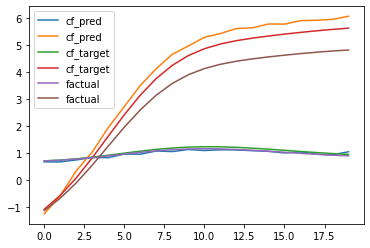

In [21]:
idx = 2
plt.plot(X_pred[idx].detach().cpu().T, label = "cf_pred")
plt.plot(X_target[idx].detach().cpu().T, label = "cf_target")
plt.plot(Y_fact[idx].detach().cpu().T, label = "factual")
plt.legend()
plt.show()

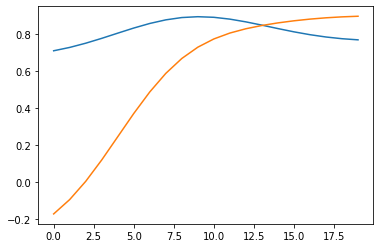

In [34]:
plt.plot(Y_fact[idx].detach().cpu().T)
#plt.plot(X_target[idx].detach().cpu().T)